<a href="https://colab.research.google.com/github/EhtashamulHaque/Potato-Leaf-Disease-Detection-using-Deep-Learning/blob/main/Potato_Disease_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [7]:
!pip install tensorflow_addons

In [8]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [9]:
import keras
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import pathlib
import seaborn as sns
import tensorflow as tf
import tensorflow_addons as tfa

from keras.utils import plot_model
from imblearn.over_sampling import SMOTE
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.layers import BatchNormalization, Conv2D, Conv2DTranspose, Dense, Dropout, Flatten, GlobalAveragePooling2D, Input, MaxPooling2D
from keras.models import Model, Sequential
from keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_curve, roc_curve, roc_auc_score
from tensorflow.keras.applications import ResNet50V2, VGG16, InceptionV3
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from keras.models import load_model
from keras.utils import load_img,img_to_array

In [10]:
folder = '/content/drive/MyDrive/plant Village/PlantVillage'


<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=256x256 at 0x7EBC4896EA40>


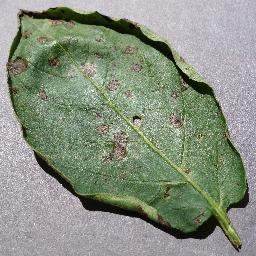

In [11]:
photo = load_img('/content/drive/MyDrive/plant Village/PlantVillage/Potato___Early_blight/009c8c31-f22d-4ffd-8f16-189c6f06c577___RS_Early.B 7885.JPG')
print(photo)
photo

In [12]:
IMG_SIZE = 128
DIM = (IMG_SIZE, IMG_SIZE)

ZOOM = [.99, 1.01]
BRIGHT_RANGE = [0.8, 1.2]
HORZ_FLIP = True
FILL_MODE = "constant"
DATA_FORMAT = "channels_last"

In [13]:
train_generator = ImageDataGenerator(rescale = 1./255, brightness_range=BRIGHT_RANGE, zoom_range=ZOOM,
                                     data_format=DATA_FORMAT, fill_mode=FILL_MODE, horizontal_flip=HORZ_FLIP)
train_data_gen = train_generator.flow_from_directory(directory=folder, target_size=DIM, batch_size=6500, shuffle=False)

Found 2000 images belonging to 2 classes.


In [14]:
train_data, train_labels = train_data_gen.next()

In [15]:
#Synthetic Minority Over-sampling Technique
sm = SMOTE(random_state=42)

train_data, train_labels = sm.fit_resample(train_data.reshape(-1, IMG_SIZE * IMG_SIZE * 3), train_labels)

print(train_data.shape, train_labels.shape)

(2000, 49152) (2000, 1)


In [16]:
train_data = train_data.reshape(-1, IMG_SIZE, IMG_SIZE, 3)
print(train_data.shape, train_labels.shape)

(2000, 128, 128, 3) (2000, 1)


In [17]:
train_labels = train_labels.reshape(-1, 1)

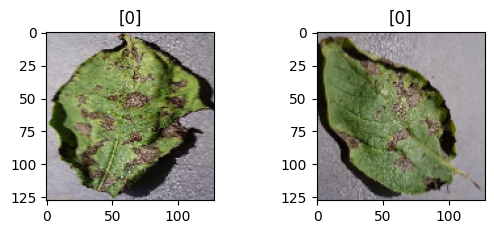

In [18]:
for i in range(2):
    plt.subplot(2,2,1+i)
    plt.title(train_labels[i])
    plt.imshow(train_data[i])

In [19]:
from sklearn.model_selection import train_test_split

In [20]:
train_data, test_data, train_labels,test_labels = train_test_split(train_data, train_labels, test_size = 0.2, random_state=42)

train_data, val_data, train_labels,val_labels = train_test_split(train_data, train_labels, test_size = 0.2, random_state=42)

In [21]:
from keras.layers import MaxPool2D


act = 'relu'
IMAGE_SIZE = (128, 128)

cnn_model = Sequential([
Input(shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3)),
Conv2D(16, 3, activation=act, padding='same'),
Conv2D(16, 3, activation=act, padding='same'),
BatchNormalization(),
MaxPool2D(),
Conv2D(32, 3, activation=act, padding='same'),
Conv2D(32, 3, activation=act, padding='same'),
BatchNormalization(),
MaxPool2D(),
Conv2D(64, 3, activation=act, padding='same'),
Conv2D(64, 3, activation=act, padding='same'),
Conv2D(64, 3, activation=act, padding='same'),
BatchNormalization(),
MaxPool2D(),
Dropout(0.2),
Conv2D(128, 3, activation=act, padding='same'),
Conv2D(128, 3, activation=act, padding='same'),
Conv2D(128, 3, activation=act, padding='same'),
BatchNormalization(),
    MaxPool2D(),
Dropout(0.2),
Conv2D(256, 3, activation=act, padding='same'),
Conv2D(256, 3, activation=act, padding='same'),
Conv2D(256, 3, activation=act, padding='same'),
BatchNormalization(),
MaxPool2D(),
Dropout(0.2),
Flatten(),
Dense(512, activation=act),
BatchNormalization(),
Dropout(0.7),
Dense(128, activation=act),
BatchNormalization(),
Dropout(0.5),
Dense(64, activation=act),
BatchNormalization(),
Dropout(0.3),
Dense(1, activation='sigmoid')
], name='cnn_model')

In [22]:
# Compile the model
cnn_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

cnn_model.summary()

Model: "cnn_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 128, 128, 16)      448       
                                                                 
 conv2d_1 (Conv2D)           (None, 128, 128, 16)      2320      
                                                                 
 batch_normalization (Batch  (None, 128, 128, 16)      64        
 Normalization)                                                  
                                                                 
 max_pooling2d (MaxPooling2  (None, 64, 64, 16)        0         
 D)                                                              
                                                                 
 conv2d_2 (Conv2D)           (None, 64, 64, 32)        4640      
                                                                 
 conv2d_3 (Conv2D)           (None, 64, 64, 32)        92

In [23]:
tf.keras.backend.set_image_data_format('channels_first')

In [24]:
# Fit the model to the training data
history = cnn_model.fit(train_data, train_labels, epochs=50, verbose=1)

# Store accuracy and loss history for each epoch
cnn_accuracy_history = history.history['accuracy']
cnn_loss_history = history.history['loss']

Epoch 1/50
40/40 [==============================] - 17s 44ms/step - loss: 0.5702 - accuracy: 0.7297
Epoch 2/50
40/40 [==============================] - 2s 43ms/step - loss: 0.3630 - accuracy: 0.8508
Epoch 3/50
40/40 [==============================] - 2s 42ms/step - loss: 0.2574 - accuracy: 0.8969
Epoch 4/50
40/40 [==============================] - 2s 41ms/step - loss: 0.1642 - accuracy: 0.9312
Epoch 5/50
40/40 [==============================] - 2s 42ms/step - loss: 0.1111 - accuracy: 0.9594
Epoch 6/50
40/40 [==============================] - 2s 41ms/step - loss: 0.0879 - accuracy: 0.9734
Epoch 7/50
40/40 [==============================] - 2s 41ms/step - loss: 0.0990 - accuracy: 0.9625
Epoch 8/50
40/40 [==============================] - 2s 42ms/step - loss: 0.0545 - accuracy: 0.9852
Epoch 9/50
40/40 [==============================] - 2s 44ms/step - loss: 0.0883 - accuracy: 0.9695
Epoch 10/50
40/40 [==============================] - 2s 43ms/step - loss: 0.0772 - accuracy: 0.9711
Epoch 11

In [25]:
loss, accuracy = cnn_model.evaluate(test_data, test_labels)
print("Accuracy: {:.2f}%".format(accuracy*100))

13/13 [==============================] - 1s 61ms/step - loss: 0.1286 - accuracy: 0.9450
Accuracy: 94.50%


In [26]:
y_pred = np.round(cnn_model.predict(test_data)).astype(int)

target_names = ['Potato___Early_blight', 'Potato___Late_blight']
report = classification_report(test_labels, y_pred, target_names=target_names, output_dict=True)

for target_name in target_names:
    precision = report[target_name]['precision']
    recall = report[target_name]['recall']
    f1_score = report[target_name]['f1-score']

# Average precision, recall, and F1-score
avg_precision = report['weighted avg']['precision']
avg_recall = report['weighted avg']['recall']
avg_f1_score = report['weighted avg']['f1-score']

print('Average Precision: {:.2f}%'.format(avg_precision*100))
print('Average Recall: {:.2f}%'.format(avg_recall*100))
print('Average F1 Score: {:.2f}%'.format(avg_f1_score*100))

cnn_precision = avg_precision
cnn_recall = avg_recall
cnn_f1score = avg_f1_score

13/13 [==============================] - 1s 11ms/step
Average Precision: 94.95%
Average Recall: 94.50%
Average F1 Score: 94.48%


13/13 [==============================] - 0s 10ms/step


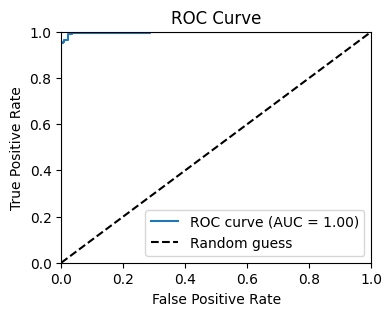

In [27]:
# Get predicted probabilities for test set
y_pred_prob = cnn_model.predict(test_data)

# Get false positive rate, true positive rate, and thresholds
fpr, tpr, thresholds = roc_curve(test_labels, y_pred_prob)

# Compute AUC score
roc_auc = roc_auc_score(test_labels, y_pred_prob)

# Plot ROC curve
plt.figure(figsize=(4,3))
plt.plot(fpr, tpr, label='ROC curve (AUC = {:.2f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], 'k--', label='Random guess')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()

13/13 [==============================] - 0s 13ms/step


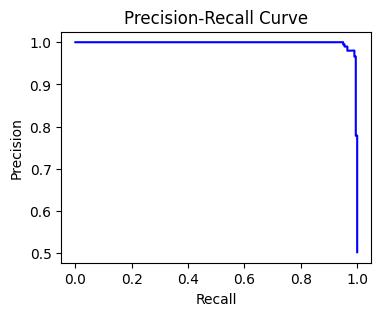

In [28]:
y_scores = cnn_model.predict(test_data)
precision, recall, _ = precision_recall_curve(test_labels, y_scores)

plt.figure(figsize=(4,3)) # set figure size
plt.plot(recall, precision, color='b')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.show()

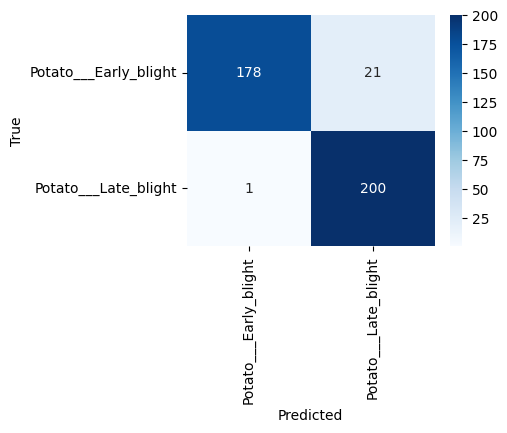

In [29]:
# your code here
cm = confusion_matrix(test_labels, y_pred)
plt.figure(figsize=(4, 3))
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', xticklabels=target_names, yticklabels=target_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

In [30]:
from keras import backend as K

K.set_image_data_format('channels_last')
vgg_model = VGG16(weights='imagenet', include_top=False, input_shape=(128, 128, 3))

58889256/58889256 [==============================] - 0s 0us/step


In [31]:
for layer in vgg_model.layers:
    layer.trainable = False

In [32]:
vgg16_model = Sequential([
    vgg_model,
    Flatten(),
    BatchNormalization(),
    Dense(512, activation='relu'),
    BatchNormalization(),
    Dropout(0.5),
    Dense(256, activation='relu'),
    BatchNormalization(),
    Dropout(0.5),
    Dense(128, activation='relu'),
    BatchNormalization(),
    Dropout(0.5),
    Dense(64, activation='relu'),
    Dropout(0.5),
    BatchNormalization(),
    Dense(1, activation='sigmoid')
], name="vgg16_model")

In [33]:
vgg16_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
vgg16_model.summary()

Model: "vgg16_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 4, 4, 512)         14714688  
                                                                 
 flatten_1 (Flatten)         (None, 8192)              0         
                                                                 
 batch_normalization_8 (Bat  (None, 8192)              32768     
 chNormalization)                                                
                                                                 
 dense_4 (Dense)             (None, 512)               4194816   
                                                                 
 batch_normalization_9 (Bat  (None, 512)               2048      
 chNormalization)                                                
                                                                 
 dropout_6 (Dropout)         (None, 512)               

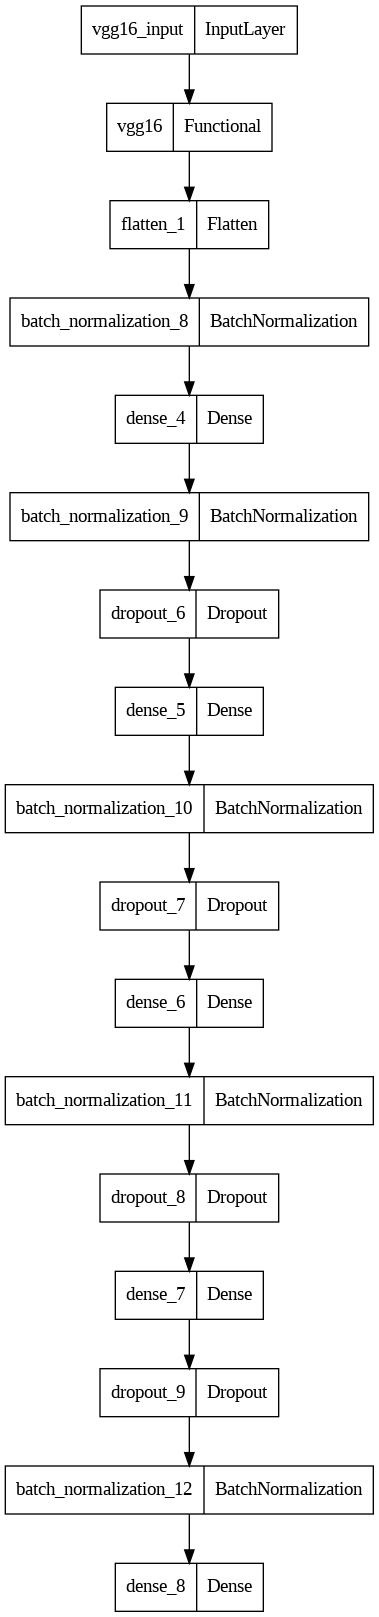

In [34]:
plot_model(vgg16_model)

In [35]:
# Fit the model to the training data
vgg16_history = vgg16_model.fit(train_data, train_labels, epochs=50, verbose=1)

# Store accuracy and loss history for each epoch
vgg16_accuracy_history = vgg16_history.history['accuracy']
vgg16_loss_history = vgg16_history.history['loss']

Epoch 1/50
40/40 [==============================] - 8s 43ms/step - loss: 0.5631 - accuracy: 0.7195
Epoch 2/50
40/40 [==============================] - 2s 45ms/step - loss: 0.3219 - accuracy: 0.8703
Epoch 3/50
40/40 [==============================] - 2s 46ms/step - loss: 0.1908 - accuracy: 0.9281
Epoch 4/50
40/40 [==============================] - 2s 44ms/step - loss: 0.1562 - accuracy: 0.9484
Epoch 5/50
40/40 [==============================] - 2s 44ms/step - loss: 0.1345 - accuracy: 0.9508
Epoch 6/50
40/40 [==============================] - 2s 44ms/step - loss: 0.1025 - accuracy: 0.9641
Epoch 7/50
40/40 [==============================] - 2s 44ms/step - loss: 0.0846 - accuracy: 0.9719
Epoch 8/50
40/40 [==============================] - 2s 44ms/step - loss: 0.0646 - accuracy: 0.9789
Epoch 9/50
40/40 [==============================] - 2s 44ms/step - loss: 0.0505 - accuracy: 0.9852
Epoch 10/50
40/40 [==============================] - 2s 46ms/step - loss: 0.0440 - accuracy: 0.9891
Epoch 11/

In [36]:
loss, accuracy = vgg16_model.evaluate(test_data, test_labels)
print("Accuracy: {:.2f}%".format(accuracy*100))

13/13 [==============================] - 3s 188ms/step - loss: 0.2236 - accuracy: 0.9425
Accuracy: 94.25%


In [37]:
y_pred = np.round(vgg16_model.predict(test_data)).astype(int)

target_names = ['Potato___Early_blight', 'Potato___Late_blight']
report = classification_report(test_labels, y_pred, target_names=target_names, output_dict=True)

for target_name in target_names:
    precision = report[target_name]['precision']
    recall = report[target_name]['recall']
    f1_score = report[target_name]['f1-score']

# Average precision, recall, and F1-score
avg_precision = report['weighted avg']['precision']
avg_recall = report['weighted avg']['recall']
avg_f1_score = report['weighted avg']['f1-score']

print('Average Precision: {:.2f}%'.format(avg_precision*100))
print('Average Recall: {:.2f}%'.format(avg_recall*100))
print('Average F1 Score: {:.2f}%'.format(avg_f1_score*100))

vgg16_precision = avg_precision
vgg16_recall = avg_recall
vgg16_f1score = avg_f1_score

13/13 [==============================] - 1s 39ms/step
Average Precision: 94.26%
Average Recall: 94.25%
Average F1 Score: 94.25%


13/13 [==============================] - 1s 40ms/step


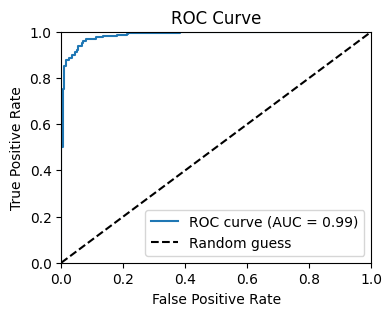

In [38]:
# Get predicted probabilities for test set
y_pred_prob_tl = vgg16_model.predict(test_data)

# Get false positive rate, true positive rate, and thresholds
fpr, tpr, thresholds = roc_curve(test_labels, y_pred_prob_tl)

# Compute AUC score
roc_auc = roc_auc_score(test_labels, y_pred_prob_tl)

# Plot ROC curve
plt.figure(figsize=(4,3))
plt.plot(fpr, tpr, label='ROC curve (AUC = {:.2f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], 'k--', label='Random guess')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()

13/13 [==============================] - 0s 39ms/step


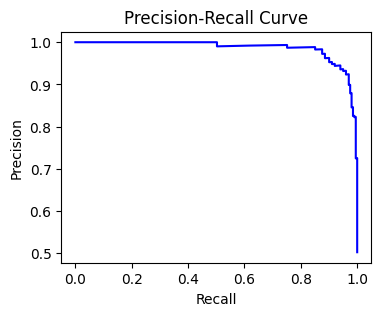

In [39]:
y_scores = vgg16_model.predict(test_data)
precision, recall, _ = precision_recall_curve(test_labels, y_scores)

plt.figure(figsize=(4,3)) # set figure size
plt.plot(recall, precision, color='b')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.show()

In [40]:
# Load the pre-trained ResNet50V2 model
resnet50v2 = ResNet50V2(include_top=False, weights='imagenet', input_shape=(128, 128, 3))

# Freeze the layers in the pre-trained model
for layer in resnet50v2.layers:
    layer.trainable = False

94668760/94668760 [==============================] - 0s 0us/step


In [41]:
ResNet50V2_model = Sequential([
    resnet50v2,
    Flatten(),
    Dense(512, activation='relu'),
    BatchNormalization(),
    Dropout(0.5),
    Dense(256, activation='relu'),
    BatchNormalization(),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
], name="ResNet50V2_model")

In [42]:
ResNet50V2_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

ResNet50V2_model.summary()

Model: "ResNet50V2_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50v2 (Functional)     (None, 4, 4, 2048)        23564800  
                                                                 
 flatten_2 (Flatten)         (None, 32768)             0         
                                                                 
 dense_9 (Dense)             (None, 512)               16777728  
                                                                 
 batch_normalization_13 (Ba  (None, 512)               2048      
 tchNormalization)                                               
                                                                 
 dropout_10 (Dropout)        (None, 512)               0         
                                                                 
 dense_10 (Dense)            (None, 256)               131328    
                                                  

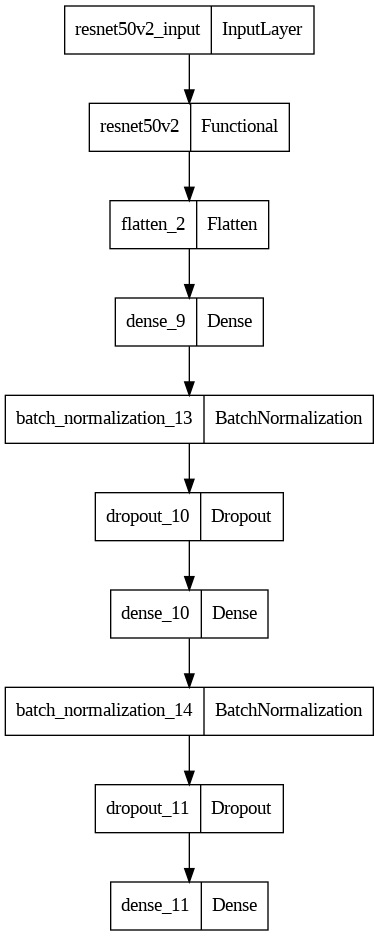

In [43]:
plot_model(ResNet50V2_model)

In [44]:
ResNet50V2_model_history = ResNet50V2_model.fit(train_data, train_labels, epochs=50, verbose=1)

# Store accuracy and loss history for each epoch
ResNet_accuracy_history = ResNet50V2_model_history.history['accuracy']
ResNet_loss_history = ResNet50V2_model_history.history['loss']

Epoch 1/50
40/40 [==============================] - 8s 37ms/step - loss: 0.2775 - accuracy: 0.8961
Epoch 2/50
40/40 [==============================] - 2s 38ms/step - loss: 0.1119 - accuracy: 0.9602
Epoch 3/50
40/40 [==============================] - 1s 37ms/step - loss: 0.0697 - accuracy: 0.9703
Epoch 4/50
40/40 [==============================] - 1s 36ms/step - loss: 0.0432 - accuracy: 0.9844
Epoch 5/50
40/40 [==============================] - 1s 36ms/step - loss: 0.0209 - accuracy: 0.9953
Epoch 6/50
40/40 [==============================] - 1s 36ms/step - loss: 0.0286 - accuracy: 0.9914
Epoch 7/50
40/40 [==============================] - 1s 36ms/step - loss: 0.0227 - accuracy: 0.9891
Epoch 8/50
40/40 [==============================] - 2s 38ms/step - loss: 0.0228 - accuracy: 0.9906
Epoch 9/50
40/40 [==============================] - 2s 39ms/step - loss: 0.0288 - accuracy: 0.9914
Epoch 10/50
40/40 [==============================] - 2s 39ms/step - loss: 0.0146 - accuracy: 0.9969
Epoch 11/

In [45]:
loss, accuracy = ResNet50V2_model.evaluate(test_data, test_labels)
print("Accuracy: {:.2f}%".format(accuracy*100))

13/13 [==============================] - 3s 131ms/step - loss: 0.1457 - accuracy: 0.9650
Accuracy: 96.50%


In [46]:
y_pred = np.round(ResNet50V2_model.predict(test_data)).astype(int)

target_names = ['Potato___Early_blight', 'Potato___Late_blight']
report = classification_report(test_labels, y_pred, target_names=target_names, output_dict=True)

for target_name in target_names:
    precision = report[target_name]['precision']
    recall = report[target_name]['recall']
    f1_score = report[target_name]['f1-score']

# Average precision, recall, and F1-score
avg_precision = report['weighted avg']['precision']
avg_recall = report['weighted avg']['recall']
avg_f1_score = report['weighted avg']['f1-score']

print('Average Precision: {:.2f}%'.format(avg_precision*100))
print('Average Recall: {:.2f}%'.format(avg_recall*100))
print('Average F1 Score: {:.2f}%'.format(avg_f1_score*100))

ResNet_precision = avg_precision
ResNet_recall = avg_recall
ResNet_f1score = avg_f1_score

13/13 [==============================] - 1s 35ms/step
Average Precision: 96.52%
Average Recall: 96.50%
Average F1 Score: 96.50%


13/13 [==============================] - 0s 30ms/step


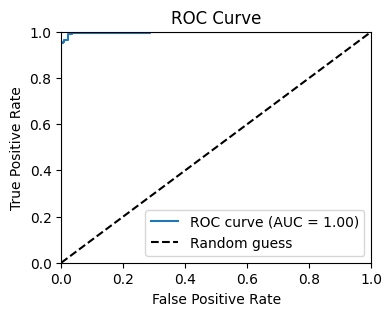

In [47]:
# Get predicted probabilities for test set
y_pred = ResNet50V2_model.predict(test_data)

fpr, tpr, thresholds = roc_curve(test_labels, y_pred_prob)
roc_auc = roc_auc_score(test_labels, y_pred_prob)
plt.figure(figsize=(4,3))
plt.plot(fpr, tpr, label='ROC curve (AUC = {:.2f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], 'k--', label='Random guess')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()

13/13 [==============================] - 0s 31ms/step


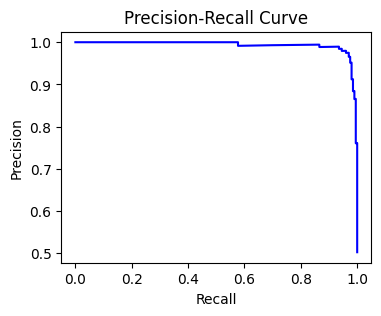

In [48]:
y_scores = ResNet50V2_model.predict(test_data)
precision, recall, _ = precision_recall_curve(test_labels, y_scores)

plt.figure(figsize=(4,3)) # set figure size
plt.plot(recall, precision, color='b')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.show()

In [49]:
# Evaluate the CNN model
cnn_loss, cnn_accuracy = cnn_model.evaluate(test_data, test_labels)

# Evaluate the VGG16 model
vgg16_loss, vgg16_accuracy = vgg16_model.evaluate(test_data, test_labels)

# Evaluate the ResNet50V2 model
resnet_loss, resnet_accuracy = ResNet50V2_model.evaluate(test_data, test_labels)

print('+-------------------------------------------------------+')
print('|{"Model Evaluation Results"} |   {"loss"} | {"accuracy"}             |')
print('+-----------------+---------------+---------------------+')
print(f'|    {"CNN Model":<15} |    {cnn_loss:.2f}      |        {cnn_accuracy:.2f}        |')
print('+-----------------+---------------+---------------------+')


print(f'|   {"VGG16 Model":<15} |    {vgg16_loss:.2f}      |        {vgg16_accuracy:.2f}        |')
print('+-----------------+---------------+---------------------+')


print(f'| {"ResNet50V2 Model":<15} |    {resnet_loss:.2f}      |        {resnet_accuracy:.2f}         |')
print('+-----------------+---------------+---------------------+')


13/13 [==============================] - 0s 33ms/step - loss: 0.1457 - accuracy: 0.9650
+-------------------------------------------------------+
|{"Model Evaluation Results"} |   {"loss"} | {"accuracy"}             |
+-----------------+---------------+---------------------+
|    CNN Model       |    0.13      |        0.94        |
+-----------------+---------------+---------------------+
|   VGG16 Model     |    0.22      |        0.94        |
+-----------------+---------------+---------------------+
| ResNet50V2 Model |    0.15      |        0.96         |
+-----------------+---------------+---------------------+


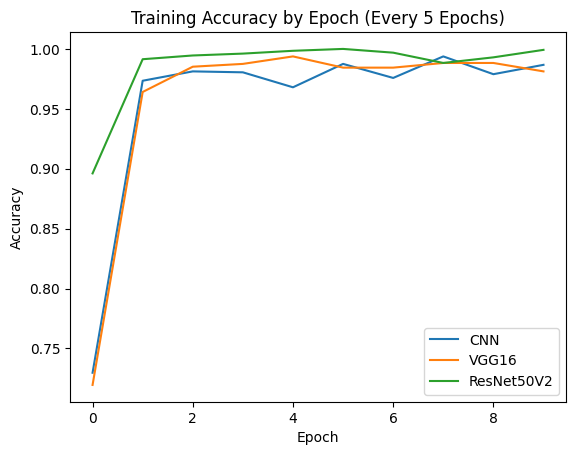

In [50]:
# Extract the accuracy history for each model every 5 epochs
cnn_history = cnn_accuracy_history[::5]
vgg16_history = vgg16_accuracy_history[::5]
resnet_history = ResNet_accuracy_history[::5]

# Plot the accuracy history for each model
plt.plot(cnn_history, label='CNN')
plt.plot(vgg16_history, label='VGG16')
plt.plot(resnet_history, label='ResNet50V2')

# Set the plot title and axis labels
plt.title('Training Accuracy by Epoch (Every 5 Epochs)')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')

# Add a legend to the plot
plt.legend()

# Show the plot
plt.show()

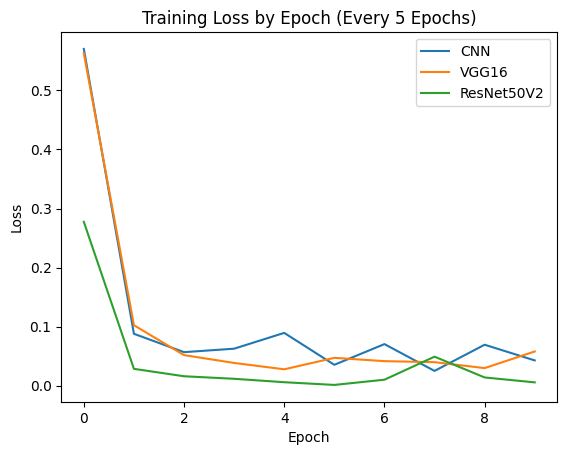

In [51]:
# Extract the loss history for each model every 5 epochs
cnn_history = cnn_loss_history[::5]
vgg16_history = vgg16_loss_history[::5]
resnet_history = ResNet_loss_history[::5]

# Plot the loss history for each model
plt.plot(cnn_history, label='CNN')
plt.plot(vgg16_history, label='VGG16')
plt.plot(resnet_history, label='ResNet50V2')

# Set the plot title and axis labels
plt.title('Training Loss by Epoch (Every 5 Epochs)')
plt.xlabel('Epoch')
plt.ylabel('Loss')

# Add a legend to the plot
plt.legend()

# Show the plot
plt.show()

In [52]:
# Create a dictionary to store the metrics
metrics_dict = {
    'Model': ['CNN', 'VGG16', 'ResNet50V2'],
   'Avg Precision': [cnn_precision*100, vgg16_precision*100, ResNet_precision*100],
        'Avg Recall': [cnn_recall*100, vgg16_recall*100, ResNet_recall*100],
        'Avg F1-Score': [cnn_f1score*100, vgg16_f1score*100, ResNet_f1score*100]
}

# Create a pandas DataFrame from the dictionary
metrics_df = pd.DataFrame(metrics_dict)

# Print the DataFrame
print(metrics_df)

        Model  Avg Precision  Avg Recall  Avg F1-Score
0         CNN      94.947180       94.50     94.484829
1       VGG16      94.259529       94.25     94.249461
2  ResNet50V2      96.518261       96.50     96.499475
